# Movie Recommendation Engine

Started as a follow-along project with [Dataquest's walkthrough](https://www.youtube.com/watch?v=eyEabQRBMQA), and ended up being a more fleshed out personal project.

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sq

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [2]:
def load_data(table_name: str) -> pd.DataFrame:
    '''
    Loads table from the movie_data sqlite database
    '''
    engine = sq.create_engine("sqlite:///data/movie_data.sql")
    with engine.connect() as cnx:
        return pd.read_sql(table_name, cnx)

In [3]:
def save_data(dataset: pd.DataFrame, table_name: str, if_exists: str = 'fail', index: bool = False) -> bool:
    '''
    Saves dataframe to the movie_data sqlite database
    '''
    engine = sq.create_engine("sqlite:///data/movie_data.sql")
    try:
        with engine.connect() as cnx:
            dataset.to_sql(name=table_name, con=cnx, if_exists=if_exists, index=index)
            return True
    except:
        print("Does this table already exist in movie_data.sql?")
        return False

In [4]:
def clean_title(title: str) -> str:
    '''
    Keeps only letters, numbers, whitespaces. 
    Replaces everything else with nothing.
    '''
    return re.sub("[^a-zA-Z0-9 ]", "", title)

In [5]:
def clean_genre(genre: str) -> list:
    '''
    Cleans the movies dataset genre columns so we can get a list of unique genres
    '''
    if '(' not in genre:
        genre_list = genre.split('|')
        return genre_list
    else:
        return ['None']

In [6]:
# separate list of genres into dummy variables
def col_lists_to_dummies(dataframe: pd.DataFrame, col_of_lists: str, identifier: str) -> pd.DataFrame:
    '''
    Turns a series of lists into dummy variables, then merges the resulting df
    with the original df.

    input
    -----
    col_of_lists: name of column where each value is a list of strings
                  this column will be turned into dummy variables
    identifier: name of column where each value uniquely identifies the row
                this column will be used to merge on
    '''
    from sklearn.preprocessing import MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # create an array of 1s and 0s representing whether or not each row belongs in the var
    dummy_array = mlb.fit_transform(dataframe[col_of_lists])
    # grab the unique vars to create new column names
    unique_vars_from_col_of_lists = mlb.classes_
    identifier_array = dataframe[identifier].values
    # create dummy dataframe
    dummy_df = pd.DataFrame(dummy_array, columns=unique_vars_from_col_of_lists, index=identifier_array).reset_index()
    dummy_df = dummy_df.rename({'index':identifier}, axis=1)

    return dummy_df, unique_vars_from_col_of_lists

In [7]:
movies = load_data('movies')
ratings = pd.read_csv("data/ratings.csv")

links = load_data('links')
tags = load_data('tags')
genome_scores = pd.read_csv('data/genome-scores.csv')
genome_tags = load_data('genome_tags')

In [14]:
movies['cleaned_title'] = movies['title'].apply(clean_title)
movies['genres_lists'] = movies['genres'].apply(clean_genre)
movies.head()

,movieId,title,genres,genres_split,cleaned_title,genres_lists
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story 1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",Jumanji 1995,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",Grumpier Old Men 1995,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",Waiting to Exhale 1995,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],Father of the Bride Part II 1995,[Comedy]


## Genre

In [15]:
# create dummy_df and get a unique list of genres
genre_dummies, unique_genres = col_lists_to_dummies(movies, 'genres_lists', 'movieId')
# mnerge dummy dataframe with original dataframe
movies_with_dummies = movies.merge(genre_dummies, on='movieId')
movies_with_dummies.head()

,movieId,title,genres,genres_split,cleaned_title,genres_lists,Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,None,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story 1995,"[Adventure, Animation, Children, Comedy, Fantasy]",0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",Jumanji 1995,"[Adventure, Children, Fantasy]",0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",Grumpier Old Men 1995,"[Comedy, Romance]",0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",Waiting to Exhale 1995,"[Comedy, Drama, Romance]",0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],Father of the Bride Part II 1995,[Comedy],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
movies_per_genre = movies_with_dummies[unique_genres.tolist() + ['movieId']].melt('movieId').groupby('variable').sum()
movies_per_genre = movies_per_genre.sort_values('value', ascending=False)[['value']].reset_index()
movies_per_genre.head()

,variable,value
0,Drama,25606
1,Comedy,16870
2,Thriller,8654
3,Romance,7719
4,Action,7348


Text(0.5, 1.0, 'Number of movies that belong to each genre')

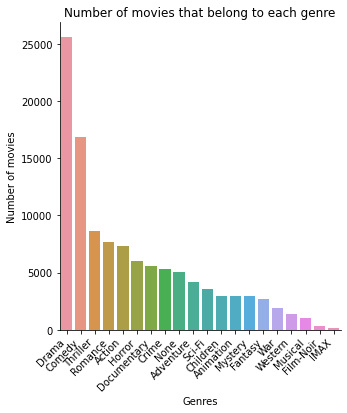

In [17]:
sns.catplot(x='variable', y='value', data=movies_per_genre, kind='bar')
plt.xticks(horizontalalignment='right', rotation=45)
plt.ylabel('Number of movies')
plt.xlabel('Genres')
plt.title('Number of movies that belong to each genre')

## Tags

# Search Engine

Converting words into numbers:

1. Term frequency: get frequency of words in title
1. Inverse document frequency: helps search engine find unique terms (the is in a lot of title, but harry is not)
1. Tf\*Idf: Get a vector for each movie

Search:

1. Convert search text into into numbers like above
1. Find row with the most number of matches via similarity

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
tags = tags.dropna()

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf = vectorizer.fit_transform(tags['tag'])

In [21]:
tfidf

<1093344x97929 sparse matrix of type '<class 'numpy.float64'>'
	with 2415931 stored elements in Compressed Sparse Row format>

In [22]:
# ngrams: number of words to search for together
# ex: Toy Story 1995: "toy", "story", "1995"; "toy story", "story 1995"
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf = vectorizer.fit_transform(movies['cleaned_title'])

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

def search(title: str, dataframe: pd.DataFrame, tfidf) -> pd.DataFrame:
    '''
    Turns search term into a vectory, resulting top 5 results
    '''
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    # returns how similar search title is to each title
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    dataframe_cp = dataframe.copy()
    # find the 5 most similar titles by idx, in asc order
    # kinda like df['col'].sort_values(ascending=False).loc[:-5]
    indices = np.argpartition(similarity, -5)[-5:]
    dataframe_cp['similarity'] = similarity
    results = dataframe_cp.iloc[indices][::-1] # return with most similar up top
    return results

In [24]:
def check_genre(value: str, genre_list: list) -> bool:
    '''
    Returns true if any of genre from list is also in the given string.
    '''
    bool_list = [True if genre in value else False for genre in genre_list]
    if sum(bool_list) > 0:
        return True
    else: 
        return False

In [25]:
movies[~movies['genres'].apply(check_genre, genre_list = list(unique_genres))]

,movieId,title,genres,genres_split,cleaned_title,genres_lists
15881,83773,Away with Words (San tiao ren) (1999),(no genres listed),[(no genres listed)],Away with Words San tiao ren 1999,[None]
16060,84768,Glitterbug (1994),(no genres listed),[(no genres listed)],Glitterbug 1994,[None]
16351,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed),[(no genres listed)],Age of the Earth The A Idade da Terra 1980,[None]
16491,87061,Trails (Veredas) (1978),(no genres listed),[(no genres listed)],Trails Veredas 1978,[None]
17404,91246,Milky Way (Tejút) (2007),(no genres listed),[(no genres listed)],Milky Way Tejt 2007,[None]
...,...,...,...,...,...,...
62400,209101,Hua yang de nian hua (2001),(no genres listed),[(no genres listed)],Hua yang de nian hua 2001,[None]
62401,209103,Tsar Ivan the Terrible (1991),(no genres listed),[(no genres listed)],Tsar Ivan the Terrible 1991,[None]
62407,209133,The Riot and the Dance (2018),(no genres listed),[(no genres listed)],The Riot and the Dance 2018,[None]
62415,209151,Mao Zedong 1949 (2019),(no genres listed),[(no genres listed)],Mao Zedong 1949 2019,[None]


## Search Box

In [27]:
import ipywidgets as widgets
from IPython.display import display

In [28]:
movie_input = widgets.Text(
    value="Toy Story",
    description="Movie Title:",
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type,names='value')
display(movie_input, movie_list)

Text(value='Toy Story', description='Movie Title:')

Output()

# Recommendation Engine

1. Find all users who liked the search title
1. Find the other movies that those users liked

In [30]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [31]:
movie_id = 1
high_rating = 4

In [32]:
# find the users that liked the movie being searched for
similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings['rating']>=high_rating)]['userId'].unique()

# find the movies that similar users liked
similar_user_recs = ratings[(ratings['userId'].isin(similar_users)) & (ratings['rating']>=high_rating)]['movieId']

In [40]:
similar_users

array([     3,      5,      8, ..., 162530, 162533, 162534])

In [43]:
def negative_bold(val):


    bold = 'bold' if val < 0 else ''


    return 'font-weight: %s' % bold

In [56]:
from typing import List

def extract_string(my_string: str, terms_to_extract: List[str]) -> str:
    new_string = ''
    my_list = my_string.split('|')
    for term in terms_to_extract:
        if term.strip() in my_list:
            new_string += f"{term.strip()}|"
    return new_string

In [57]:
extract_string('i|am|groot', ['i', 'groot'])

['i', 'am', 'groot']


'i|groot|'

In [34]:
# find the top 10% of movies
similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
similar_user_recs = similar_user_recs[similar_user_recs > 0.1]
similar_user_recs

1       1.000000
318     0.549604
260     0.531518
356     0.517224
296     0.495744
          ...   
235     0.101249
1242    0.100931
1907    0.100772
3527    0.100613
2761    0.100135
Name: movieId, Length: 273, dtype: float64

In [35]:
# find what percent of people not similar to us liked these movies
# if normies like what i like, its highly likely the "similar users" liked my
# movie because everyone liked it

In [36]:
# all users who watched the movie recommended to us
all_users = ratings[(ratings['movieId'].isin(similar_user_recs.index)) & (ratings['rating'] >= high_rating)]

In [37]:
# all users who watched the movie recommended to us
all_users = ratings[(ratings['movieId'].isin(similar_user_recs.index)) & (ratings['rating'] >= high_rating)]
all_user_recs = all_users['movieId'].value_counts()/len(all_users['userId'].unique())

We need to find a movie where:

1. Everyone who liked search_term, also liked rec_term
1. Only X% (40%, ex) of those who liked rec_term also liked search_term

In [38]:
# percent of all users who liked the given movie
all_user_recs

318     0.440215
296     0.389659
356     0.367553
593     0.361897
2571    0.347994
          ...   
3175    0.049325
2081    0.047128
1282    0.044712
2761    0.039855
1907    0.039805
Name: movieId, Length: 273, dtype: float64

In [ ]:
rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
rec_percentages.columns = ['similar_ppl','all_ppl']

In [ ]:
rec_percentages

In [ ]:
# score = ratio of similar:avg users who liked movie
rec_percentages['score'] = rec_percentages['similar_ppl'] / rec_percentages['all_ppl']
rec_percentages = rec_percentages.sort_values('score', ascending=False)

In [ ]:
# left_index is the movieId
rec_percentages.head(10).merge(movies, left_index=True, right_on='movieId')

Not bad! For `Toy Story` we recommended the Toy Story series, Bugs Life, etc.

In [ ]:
def find_similar_movies(movie_id: int, high_rating: int = 4) -> pd.DataFrame:
    # find the users that liked the movie being searched for
    similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings['rating']>=high_rating)]['userId'].unique()
    # find the movies that similar users liked
    similar_user_recs = ratings[(ratings['userId'].isin(similar_users)) & (ratings['rating']>=high_rating)]['movieId']

    # find the top 10% of movies
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
    similar_user_recs = similar_user_recs[similar_user_recs > 0.1]
    
    # all users who watched the movie recommended to us
    all_users = ratings[(ratings['movieId'].isin(similar_user_recs.index)) & (ratings['rating'] >= high_rating)]
    all_user_recs = all_users['movieId'].value_counts()/len(all_users['userId'].unique())
    
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ['similar_ppl','all_ppl']

    # score = ratio of similar:avg users who liked movie
    rec_percentages['score'] = rec_percentages['similar_ppl'] / rec_percentages['all_ppl']
    rec_percentages = rec_percentages.sort_values('score', ascending=False)
    
    # left_index is the movieId
    return rec_percentages.head(10).merge(movies, left_index=True, right_on='movieId')[['score','title','genres']]

## Widget

In [ ]:
movie_input_name = widgets.Text(
    initial_value = 'Toy Story',
    description = 'Movie Title:',
    disabled=False
)

In [ ]:
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data['new']
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]['movieId']
            display(find_similar_movies(movie_id))

movie_input_name.observe(on_type, names='value')
display(movie_input_name, recommendation_list)

# Adding Tags as a Feature

In [ ]:
tags = tags.merge(genome_tags, how='left')
tags.info()

In [ ]:
num_movies = len(tags['movieId'].unique())
num_real_movies = len(tags[~tags['tagId'].isna()]['movieId'].unique())

By only using movies that are tagged with a tagId, we lose {{ num_movies - num_real_movies }} movies
And analyze {{ num_real_movies }} movies

In [ ]:
def pick_highest_relevant_tag_score(sub_df: pd.DataFrame) -> pd.DataFrame:
    '''
    Used for groupby function, returns the row that contains the highest
    relevance value (minus movieId column, since groupby function will 
    make that the index anyways)
    '''
    sub_df = sub_df.sort_values('relevance', ascending=False)
    return sub_df.iloc[0,1:]
    

In [ ]:
most_relevant_tag = genome_scores.groupby('movieId').apply(pick_highest_relevant_tag_score)
most_relevant_tag = most_relevant_tag.reset_index()

In [ ]:
num_unique_tags = len(genome_scores['tagId'].unique())
num_movies_tagged = len(genome_scores['movieId'].unique())
(genome_scores['movieId'].value_counts() == num_unique_tags).sum() == num_movies_tagged

In [ ]:
genome_scores[genome_scores['relevance'] >= 0.5].iloc[0,:]

In [ ]:
genome_scores[genome_scores['relevance'] >= 0.5]

In [ ]:
genome_scores.describe().round(2)

In [ ]:
genome_scores.merge(movies).sort_values(['movieId', 'relevance'], ascending=False)